In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
from pprint import pprint

sns.set(style="whitegrid")

from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
from sklearn.model_selection import train_test_split

from sklearn import metrics 
from sklearn.feature_selection import RFE
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
import xgboost as xgb
from sklearn import tree

from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression

pd.set_option('display.max_columns', None)

In [2]:
#Read in a bunch of csv files and stack them together

path =r'C:\\Users\\armcl\\Python\\Lending Club\\Data' 
all_files = glob.glob(os.path.join(path, "*.csv"))     
df_from_each_file = (pd.read_csv(f,skiprows=[0],header=0,low_memory=False) for f in all_files)
lc_all   = pd.concat(df_from_each_file, ignore_index=True)

In [3]:
#Remove all NAs data
lc_all.dropna(subset=['loan_status'], inplace=True)

#int rate to numeric
lc_all['int_rate'] = pd.to_numeric(lc_all['int_rate'].str.replace("%", "").str.replace(" ", ""))

#Extract the initiation year feature
lc_all['issue_d'] = pd.to_datetime(lc_all['issue_d'])
lc_all['last_pymnt_d'] = pd.to_datetime(lc_all['last_pymnt_d'])
lc_all['issue_y'] = lc_all['issue_d'].dt.year

#Defaulted loans are tiny and let's relabel them to charge off
lc_all['loan_status'].replace({'Default':'Charged Off'}, inplace=True)

In [4]:
#Capture the prepaid loans

paid_off = lc_all.loc[lc_all['loan_status'].isin(['Fully Paid']),:]

paid_off['last_pymnt_d'] = pd.to_datetime(paid_off['last_pymnt_d'])
paid_off['actual_term'] = paid_off['last_pymnt_d'] - paid_off['issue_d']
paid_off['actual_term']=round(paid_off['actual_term']/np.timedelta64(1,'M'),0)

paid_off['term_num'] = paid_off['term'].replace({' 36 months':36,' 60 months':60})

paid_off['prepaid_months'] = paid_off['term_num'] - paid_off['actual_term']
paid_off.loc[paid_off['prepaid_months'] < 0, 'prepaid_months'] = 0
#76% prepaid their loans. This is really high. Maybe people rollover their loans when they get a lower interest rates.

#actual payment term / term
paid_off['prepaid_months_pct'] = (paid_off['term_num'] - paid_off['prepaid_months'])/paid_off['term_num']

paid_off['prepaid_months_pct'].mean()

C:\Users\armcl\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\armcl\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\armcl\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#

0.576753415572103

In [5]:
paid_off.loc[paid_off['term_num']==36,'prepaid_months_pct'].quantile([0,.0001,.01, .1, .25, .5, .75, .9, .99,.9999,1])

0.0000    0.000000
0.0001    0.000000
0.0100    0.027778
0.1000    0.166667
0.2500    0.333333
0.5000    0.638889
0.7500    1.000000
0.9000    1.000000
0.9900    1.000000
0.9999    1.000000
1.0000    1.000000
Name: prepaid_months_pct, dtype: float64

In [6]:
paid_off.loc[paid_off['term_num']==60,'prepaid_months_pct'].quantile([0,.0001,.01, .1, .25, .5, .75, .9, .99,.9999,1])

0.0000    0.000000
0.0001    0.000000
0.0100    0.000000
0.1000    0.066667
0.2500    0.183333
0.5000    0.366667
0.7500    0.633333
0.9000    0.916667
0.9900    1.000000
0.9999    1.000000
1.0000    1.000000
Name: prepaid_months_pct, dtype: float64

C:\Users\armcl\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


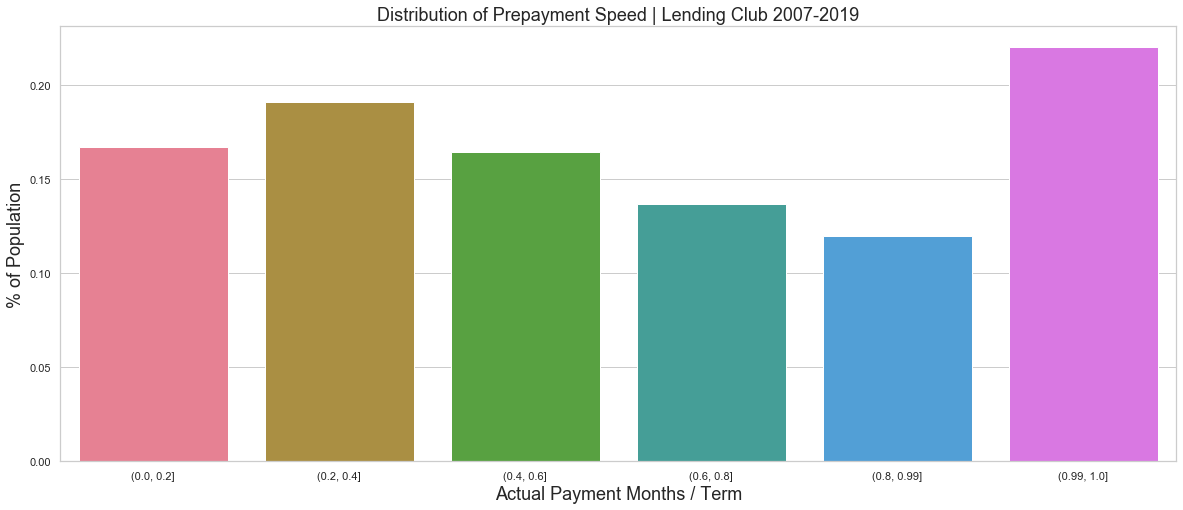

In [7]:
paid_off['prepaid_bins'] = pd.cut(x=paid_off['prepaid_months_pct'], bins=[0,.2,.4,.6,.8,.99,1])

paid_off_buckets = paid_off.groupby('prepaid_bins').count()/paid_off.groupby('prepaid_bins').count()['id'].sum()

plt.figure(figsize=(20, 8))
sns.barplot(x=paid_off_buckets.index, y=paid_off_buckets.id, palette = 'husl')

# Add labels to your graph
plt.xlabel('Actual Payment Months / Term', fontsize=18)
plt.ylabel('% of Population', fontsize=18)
plt.title("Distribution of Prepayment Speed | Lending Club 2007-2019", fontsize=18)
plt.show()

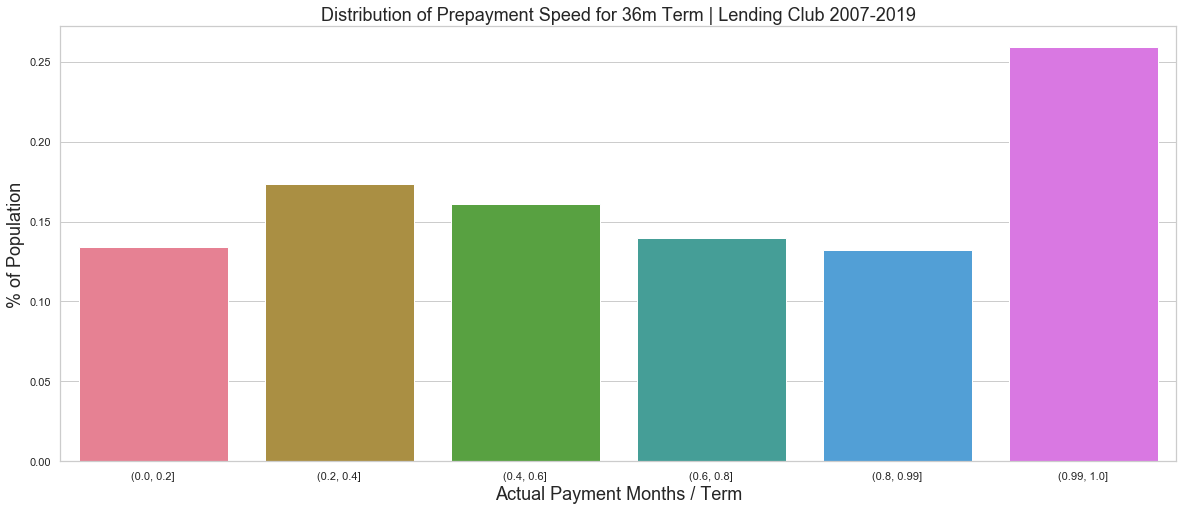

In [8]:
paid_off_buckets_36m = paid_off.loc[paid_off['term_num']==36,:].groupby('prepaid_bins').count()/paid_off.loc[paid_off['term_num']==36,:].groupby('prepaid_bins').count()['id'].sum()

plt.figure(figsize=(20, 8))
sns.barplot(x=paid_off_buckets_36m.index, y=paid_off_buckets_36m.id, palette = 'husl')

# Add labels to your graph
plt.xlabel('Actual Payment Months / Term', fontsize=18)
plt.ylabel('% of Population', fontsize=18)
plt.title("Distribution of Prepayment Speed for 36m Term | Lending Club 2007-2019", fontsize=18)
plt.show()

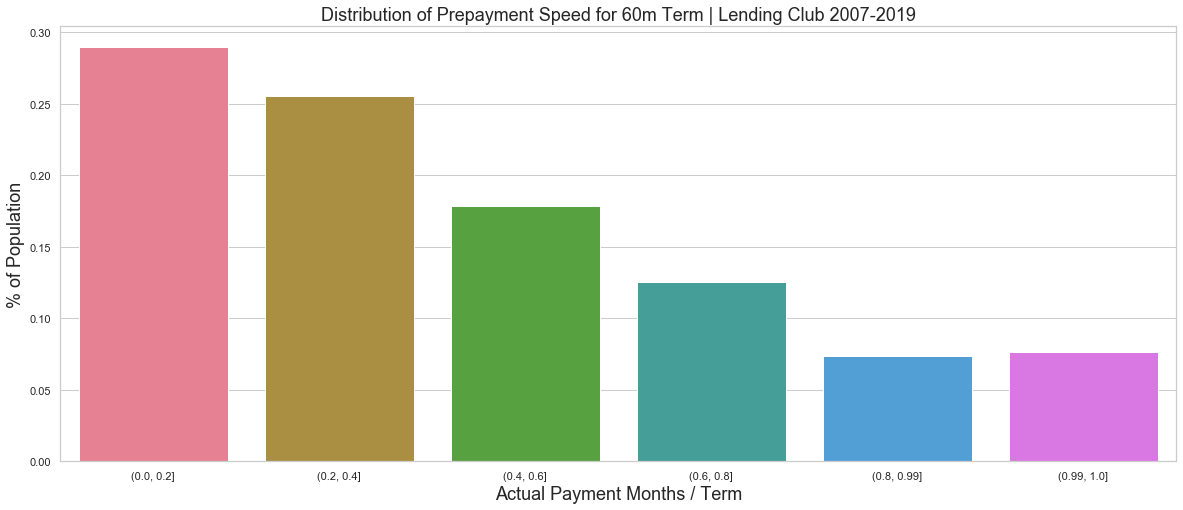

In [9]:
paid_off_buckets_60m = paid_off.loc[paid_off['term_num']==60,:].groupby('prepaid_bins').count()/paid_off.loc[paid_off['term_num']==60,:].groupby('prepaid_bins').count()['id'].sum()

plt.figure(figsize=(20, 8))
sns.barplot(x=paid_off_buckets_60m.index, y=paid_off_buckets_60m.id, palette = 'husl')

# Add labels to your graph
plt.xlabel('Actual Payment Months / Term', fontsize=18)
plt.ylabel('% of Population', fontsize=18)
plt.title("Distribution of Prepayment Speed for 60m Term | Lending Club 2007-2019", fontsize=18)
plt.show()

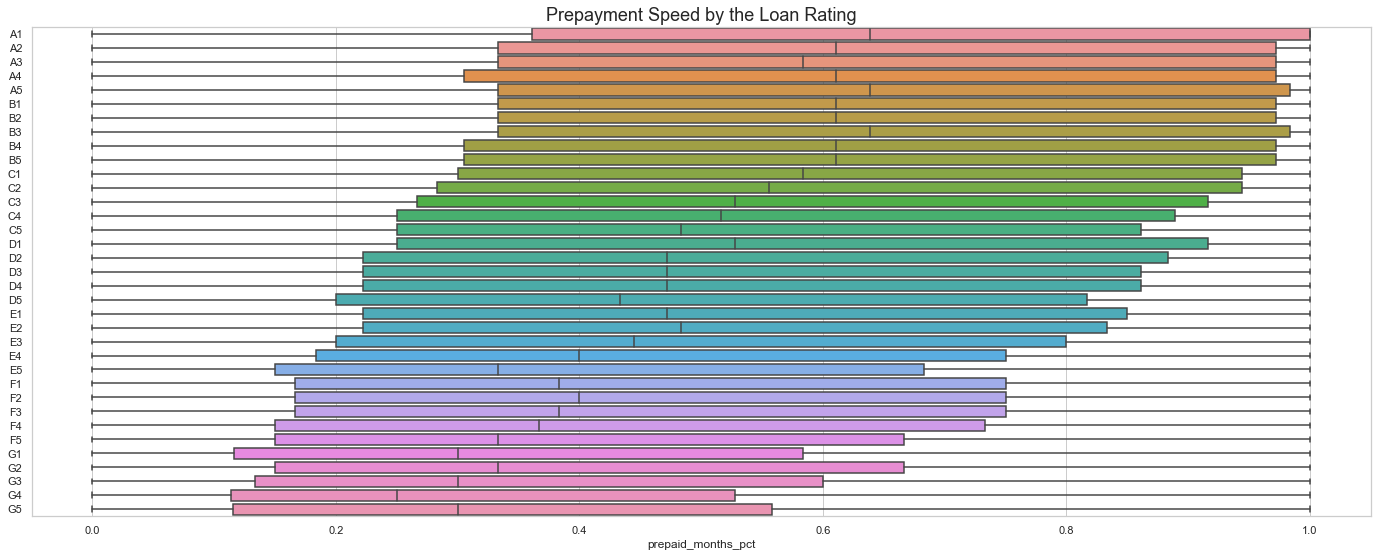

In [10]:
#This suggests the higher the interest rates, the faster the prepayment.

#Prepayment by sub group

plt.figure(figsize=(24, 9))
ax = sns.boxplot(x="prepaid_months_pct", y='sub_grade', orient="h", data=paid_off.sort_values('sub_grade'))
ax.set_title("Prepayment Speed by the Loan Rating", fontsize=18)
ax.set_ylabel('')

plt.show()

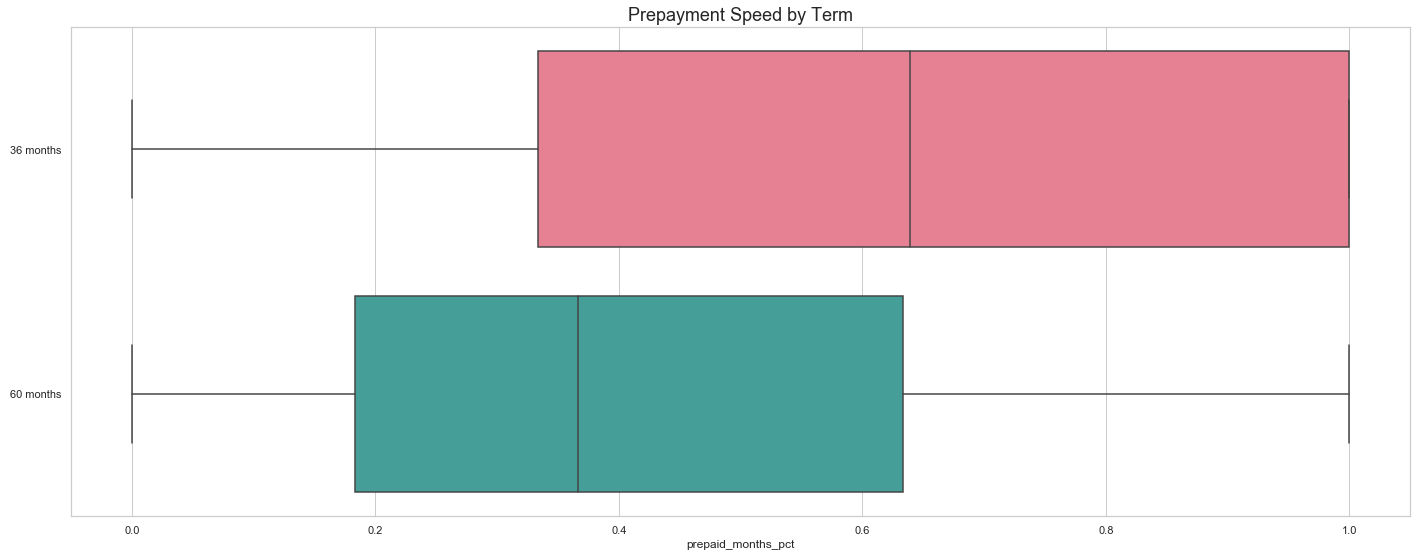

In [11]:
#This suggests the higher the interest rates, the faster the prepayment.

#Prepayment by term

plt.figure(figsize=(24, 9))
ax = sns.boxplot(x="prepaid_months_pct", y='term', orient="h", palette = 'husl', data=paid_off.sort_values('term'))
ax.set_title("Prepayment Speed by Term", fontsize=18)
ax.set_ylabel('')

plt.show()

In [97]:
#Avoid data leakage (remove features that were unknown at the time of the loan initiaion)
leakage_features = ['collection_recovery_fee','last_credit_pull_d','last_fico_range_high',
                    'last_fico_range_low','last_pymnt_amnt','last_pymnt_d','next_pymnt_d',
                    'num_tl_120dpd_2m','num_tl_30dpd','out_prncp','out_prncp_inv',
                    'recoveries','total_pymnt','total_pymnt_inv','total_rec_int',
                    'total_rec_late_fee','total_rec_prncp','debt_settlement_flag',
                    'debt_settlement_flag_date','settlement_status','settlement_date',
                    'settlement_amount','settlement_percentage','settlement_term',
                    'loan_status']

#Remove features that don't have much added information
#For example sub_grade is finer than grade
features_to_remove = leakage_features + ['emp_title','loan_amnt','funded_amnt_inv','grade',
                                         'id','member_id','title','url','zip_code',
                                         'pymnt_plan','policy_code','term_num',
                                         'prepaid_months',
                                         'actual_term']

paid_off = paid_off.drop(columns=features_to_remove)


In [98]:
#If join application, replace with the joint info

paid_off['revol_util'] = pd.to_numeric(paid_off['revol_util'].str.replace("%", ""))

paid_off.loc[paid_off['application_type']=='Joint App','annual_inc'] = paid_off.loc[paid_off['application_type']=='Joint App','annual_inc_joint']
paid_off.loc[paid_off['application_type']=='Joint App','dti'] = paid_off.loc[paid_off['application_type']=='Joint App','dti_joint']
paid_off.loc[paid_off['application_type']=='Joint App','verification_status'] = paid_off.loc[paid_off['application_type']=='Joint App','verification_status_joint']

paid_off.loc[(paid_off['application_type']=='Joint App')&(~paid_off['revol_bal_joint'].isnull()),'revol_bal'] = paid_off.loc[(paid_off['application_type']=='Joint App')&(~paid_off['revol_bal_joint'].isnull()),'revol_bal_joint']
paid_off.loc[(paid_off['application_type']=='Joint App')&(~paid_off['sec_app_fico_range_low'].isnull()),'fico_range_low'] = (paid_off.loc[(paid_off['application_type']=='Joint App')&(~paid_off['sec_app_fico_range_low'].isnull()),'fico_range_low'] + paid_off.loc[(paid_off['application_type']=='Joint App')&(~paid_off['sec_app_fico_range_low'].isnull()),'sec_app_fico_range_low'])/2
paid_off.loc[(paid_off['application_type']=='Joint App')&(~paid_off['sec_app_fico_range_high'].isnull()),'fico_range_high'] = (paid_off.loc[(paid_off['application_type']=='Joint App')&(~paid_off['sec_app_fico_range_high'].isnull()),'fico_range_high'] + paid_off.loc[(paid_off['application_type']=='Joint App')&(~paid_off['sec_app_fico_range_high'].isnull()),'sec_app_fico_range_high'])/2
paid_off.loc[(paid_off['application_type']=='Joint App')&(~paid_off['sec_app_inq_last_6mths'].isnull()),'inq_last_6mths'] = (paid_off.loc[(paid_off['application_type']=='Joint App')&(~paid_off['sec_app_inq_last_6mths'].isnull()),'inq_last_6mths'] + paid_off.loc[(paid_off['application_type']=='Joint App')&(~paid_off['sec_app_inq_last_6mths'].isnull()),'sec_app_inq_last_6mths'])/2
paid_off.loc[(paid_off['application_type']=='Joint App')&(~paid_off['sec_app_mort_acc'].isnull()),'mort_acc'] = (paid_off.loc[(paid_off['application_type']=='Joint App')&(~paid_off['sec_app_mort_acc'].isnull()),'mort_acc'] + paid_off.loc[(paid_off['application_type']=='Joint App')&(~paid_off['sec_app_mort_acc'].isnull()),'sec_app_mort_acc'])/2
paid_off.loc[(paid_off['application_type']=='Joint App')&(~paid_off['sec_app_open_acc'].isnull()),'open_acc'] = (paid_off.loc[(paid_off['application_type']=='Joint App')&(~paid_off['sec_app_open_acc'].isnull()),'open_acc'] + paid_off.loc[(paid_off['application_type']=='Joint App')&(~paid_off['sec_app_open_acc'].isnull()),'sec_app_open_acc'])/2
paid_off.loc[(paid_off['application_type']=='Joint App')&(~paid_off['sec_app_revol_util'].isnull()),'revol_util'] = (paid_off.loc[(paid_off['application_type']=='Joint App')&(~paid_off['sec_app_revol_util'].isnull()),'revol_util'] + paid_off.loc[(paid_off['application_type']=='Joint App')&(~paid_off['sec_app_revol_util'].isnull()),'sec_app_revol_util'])/2
paid_off.loc[(paid_off['application_type']=='Joint App')&(~paid_off['sec_app_open_act_il'].isnull()),'open_act_il'] = (paid_off.loc[(paid_off['application_type']=='Joint App')&(~paid_off['sec_app_open_act_il'].isnull()),'open_act_il'] + paid_off.loc[(paid_off['application_type']=='Joint App')&(~paid_off['sec_app_open_act_il'].isnull()),'sec_app_open_act_il'])/2
paid_off.loc[(paid_off['application_type']=='Joint App')&(~paid_off['sec_app_num_rev_accts'].isnull()),'num_rev_accts'] = (paid_off.loc[(paid_off['application_type']=='Joint App')&(~paid_off['sec_app_num_rev_accts'].isnull()),'num_rev_accts'] + paid_off.loc[(paid_off['application_type']=='Joint App')&(~paid_off['sec_app_num_rev_accts'].isnull()),'sec_app_num_rev_accts'])/2
paid_off.loc[(paid_off['application_type']=='Joint App')&(~paid_off['sec_app_chargeoff_within_12_mths'].isnull()),'chargeoff_within_12_mths'] = (paid_off.loc[(paid_off['application_type']=='Joint App')&(~paid_off['sec_app_chargeoff_within_12_mths'].isnull()),'chargeoff_within_12_mths'] + paid_off.loc[(paid_off['application_type']=='Joint App')&(~paid_off['sec_app_chargeoff_within_12_mths'].isnull()),'sec_app_chargeoff_within_12_mths'])/2
paid_off.loc[(paid_off['application_type']=='Joint App')&(~paid_off['sec_app_collections_12_mths_ex_med'].isnull()),'collections_12_mths_ex_med'] = (paid_off.loc[(paid_off['application_type']=='Joint App')&(~paid_off['sec_app_collections_12_mths_ex_med'].isnull()),'collections_12_mths_ex_med'] + paid_off.loc[(paid_off['application_type']=='Joint App')&(~paid_off['sec_app_collections_12_mths_ex_med'].isnull()),'sec_app_collections_12_mths_ex_med'])/2
paid_off.loc[(paid_off['application_type']=='Joint App')&(~paid_off['sec_app_mths_since_last_major_derog'].isnull()),'mths_since_last_major_derog'] = (paid_off.loc[(paid_off['application_type']=='Joint App')&(~paid_off['sec_app_mths_since_last_major_derog'].isnull()),'mths_since_last_major_derog'] + paid_off.loc[(paid_off['application_type']=='Joint App')&(~paid_off['sec_app_mths_since_last_major_derog'].isnull()),'sec_app_mths_since_last_major_derog'])/2

In [99]:
#Reduce the number of categories for home ownership
paid_off = paid_off.replace({'home_ownership' : {'ANY':'OTHER','NONE':'OTHER'}})

#Create dummy variables

paid_off = pd.concat([paid_off, paid_off['term'].str.get_dummies(sep=',')], axis=1)
paid_off = pd.concat([paid_off, paid_off['sub_grade'].str.get_dummies(sep=',')], axis=1)
paid_off = pd.concat([paid_off, pd.get_dummies(paid_off['home_ownership'],prefix="Home")], axis=1)
paid_off = pd.concat([paid_off, paid_off['verification_status'].str.get_dummies(sep=',')], axis=1)
paid_off = pd.concat([paid_off, pd.get_dummies(paid_off['purpose'],prefix="purpose")], axis=1)
paid_off = pd.concat([paid_off, paid_off['addr_state'].str.get_dummies(sep=',')], axis=1)
paid_off = pd.concat([paid_off, pd.get_dummies(paid_off['initial_list_status'],prefix="list_status")], axis=1)
paid_off = pd.concat([paid_off, paid_off['application_type'].str.get_dummies(sep=',')], axis=1)

In [100]:
#Replace categorical variables to numerical
paid_off = paid_off.replace({'emp_length' : {'< 1 year':0.5,'1 year':1,'2 years':2,'3 years':3,'4 years':4,'5 years':5,'6 years':6,'7 years':7,'8 years':8,'9 years':9,'10+ years':15}})

#Create a few new features

paid_off['loan_desc_length'] = paid_off['desc'].str.len().fillna(0)

paid_off['earliest_cr_line'] = pd.to_datetime(paid_off['earliest_cr_line'])
paid_off['cr_line_months'] = paid_off['issue_d'] - paid_off['earliest_cr_line']
paid_off['cr_line_months']=round(paid_off['cr_line_months']/np.timedelta64(1,'M'),2)

paid_off['sec_app_earliest_cr_line'] = pd.to_datetime(paid_off['sec_app_earliest_cr_line'])
paid_off['sec_app_cr_line_months'] = paid_off['issue_d'] - paid_off['sec_app_earliest_cr_line']
paid_off['sec_app_cr_line_months']=round(paid_off['sec_app_cr_line_months']/np.timedelta64(1,'M'),2)

paid_off.loc[(paid_off['application_type']=='Joint App')&(~paid_off['sec_app_cr_line_months'].isnull()),'cr_line_months'] = (paid_off.loc[(paid_off['application_type']=='Joint App')&(~paid_off['sec_app_cr_line_months'].isnull()),'cr_line_months'] + paid_off.loc[(paid_off['application_type']=='Joint App')&(~paid_off['sec_app_cr_line_months'].isnull()),'sec_app_cr_line_months'])/2

paid_off['fico_range_avg'] = (paid_off['fico_range_low'] + paid_off['fico_range_high'])/2

#And remove the joint data
features_to_remove = ['annual_inc_joint','dti_joint','verification_status_joint','revol_bal_joint','sec_app_fico_range_low','sec_app_fico_range_high','sec_app_inq_last_6mths',
                      'sec_app_mort_acc','sec_app_open_acc','sec_app_revol_util','sec_app_open_act_il','sec_app_num_rev_accts','sec_app_chargeoff_within_12_mths','sec_app_collections_12_mths_ex_med',
                      'sec_app_mths_since_last_major_derog','sec_app_cr_line_months',
                      'sec_app_earliest_cr_line']

paid_off = paid_off.drop(columns=features_to_remove)

In [101]:
#No hardship application for paid off and charged off loans, remove the irrelvant features
paid_off = paid_off.drop(lc_all.loc[:, 'hardship_flag':'hardship_last_payment_amount'].columns, axis = 1) 

#remove new features with data only after 2015
#can't fill the NaNs before 2015 since it's not randomly missing
#might worth only looking at the post 2015 data and see if any of these are important
paid_off = paid_off.drop(columns=['open_acc_6m','open_act_il','open_il_12m','open_il_24m',
                       'total_bal_il','il_util','open_rv_12m','open_rv_24m','max_bal_bc',
                       'all_util','inq_fi','total_cu_tl','inq_last_12m'])


In [102]:
#Fill Nas
#For these features, the longer the better

features_to_inverse = ['mths_since_recent_inq','mo_sin_old_il_acct',
                      'mo_sin_old_rev_tl_op','mths_since_last_delinq','mths_since_last_record',
                      'mths_since_last_major_derog','mths_since_rcnt_il','mths_since_recent_bc_dlq',
                      'mths_since_recent_revol_delinq']

for col in features_to_inverse:
    paid_off[col] = paid_off[col].fillna(2*paid_off[col].max())
    
#Remove all NAs data
paid_off.dropna(subset=['tot_coll_amt'], inplace=True)

#Features from open_acc_6m to inq_last_12m are new features released after 2015
#Use median for the 2007-2018 sample; worth only looking at the 2015-2018 sample to see if any significance

replace_median = ['dti','inq_last_6mths','revol_util',
                  'emp_length',
                  'bc_open_to_buy','avg_cur_bal','mo_sin_rcnt_rev_tl_op',
                  'bc_util','chargeoff_within_12_mths','mths_since_recent_bc','num_rev_accts',
                  'pct_tl_nvr_dlq','percent_bc_gt_75'
                  ]

for col in replace_median:
    paid_off[col] = paid_off[col].fillna(paid_off[col].median())


In [103]:
#Drop state dummy variables with less than 10000 loans in the data

bystate = paid_off.groupby('addr_state').count().sort_values('funded_amnt',ascending=False)
small_state = list(bystate[bystate['funded_amnt']<10000].index)
paid_off = paid_off.drop(columns=small_state)

#Remove observations with annual income lower than $8000 and higher than $300k
paid_off = paid_off.loc[(lc_all['annual_inc'] > 8000) & (paid_off['annual_inc'] < 300000),:]

#Create a new feature which is installment/annual income/12
paid_off['installment_to_inc'] = 100*paid_off['installment']/(paid_off['annual_inc']/12)

#dti can't be negative
paid_off = paid_off.loc[paid_off['dti'] > 0,:]

In [104]:
#Remove unneeded features
features_to_remove = ['issue_d','earliest_cr_line','term','addr_state',
                      'sub_grade','home_ownership','verification_status',
                      'purpose','initial_list_status','application_type',
                      'issue_y','desc',
                      'fico_range_high','fico_range_low','addr_state']
paid_off = paid_off.drop(columns=features_to_remove)

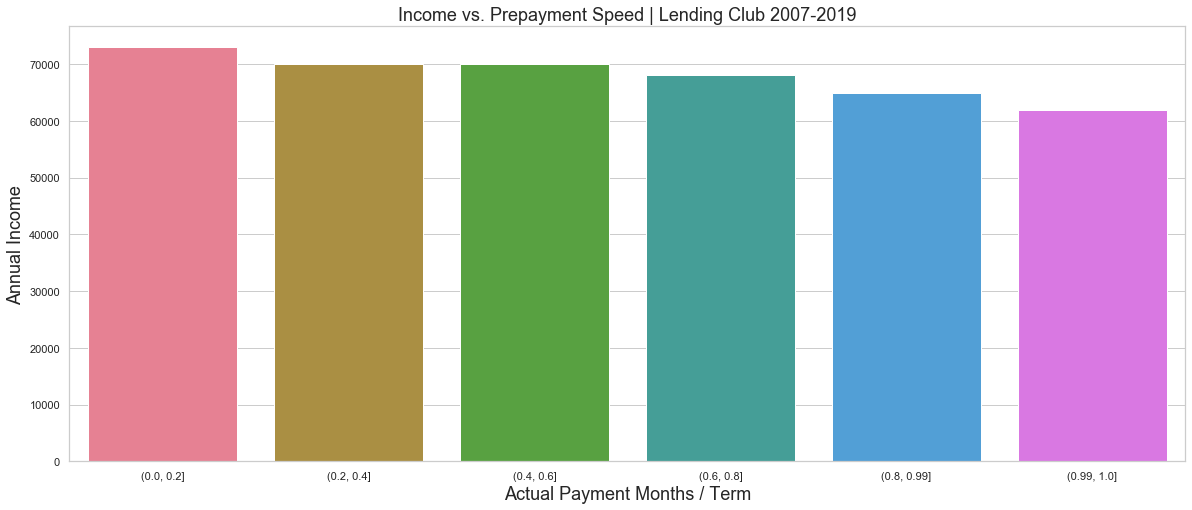

In [106]:
#Income by prepayment speed bucket
#More income, more capability to prepay earlier

paid_off_buckets = paid_off.groupby('prepaid_bins').median()

plt.figure(figsize=(20, 8))
sns.barplot(x=paid_off_buckets.index, y=paid_off_buckets.annual_inc, palette = 'husl')

# Add labels to your graph
plt.xlabel('Actual Payment Months / Term', fontsize=18)
plt.ylabel('Annual Income', fontsize=18)
plt.title("Income vs. Prepayment Speed | Lending Club 2007-2019", fontsize=18)
plt.show()

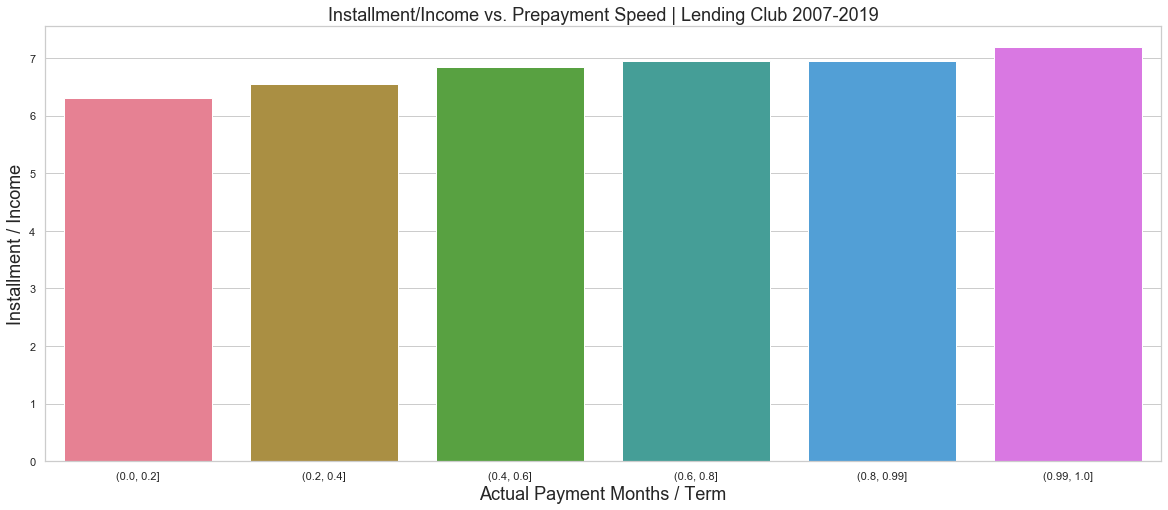

In [107]:
#Installment/Income by prepayment speed bucket

paid_off_buckets = paid_off.groupby('prepaid_bins').median()

plt.figure(figsize=(20, 8))
sns.barplot(x=paid_off_buckets.index, y=paid_off_buckets.installment_to_inc, palette = 'husl')

# Add labels to your graph
plt.xlabel('Actual Payment Months / Term', fontsize=18)
plt.ylabel('Installment / Income', fontsize=18)
plt.title("Installment/Income vs. Prepayment Speed | Lending Club 2007-2019", fontsize=18)
plt.show()

In [108]:
#Remove highly correlated features

target = ['prepaid_months_pct'] 
features = list(paid_off.drop(['prepaid_months_pct'],axis=1).columns)

corr_features = paid_off[features].corr()
np.fill_diagonal(corr_features.values, np.nan)
corr_features.unstack().sort_values(ascending=False).drop_duplicates()[0:10]

open_acc           num_sats                      0.993706
num_actv_rev_tl    num_rev_tl_bal_gt_0           0.983350
tot_hi_cred_lim    tot_cur_bal                   0.972694
funded_amnt        installment                   0.954667
cr_line_months     mo_sin_old_rev_tl_op          0.917809
total_bal_ex_mort  total_il_high_credit_limit    0.883493
revol_util         bc_util                       0.856389
bc_open_to_buy     total_bc_limit                0.852567
bc_util            percent_bc_gt_75              0.845466
num_rev_accts      num_bc_tl                     0.838334
dtype: float64

In [109]:
#Remove the highly correlated feature

highly_cor_features = ['num_sats','num_rev_tl_bal_gt_0','tot_hi_cred_lim','installment','prepaid_bins']
paid_off = paid_off.drop(columns=highly_cor_features)

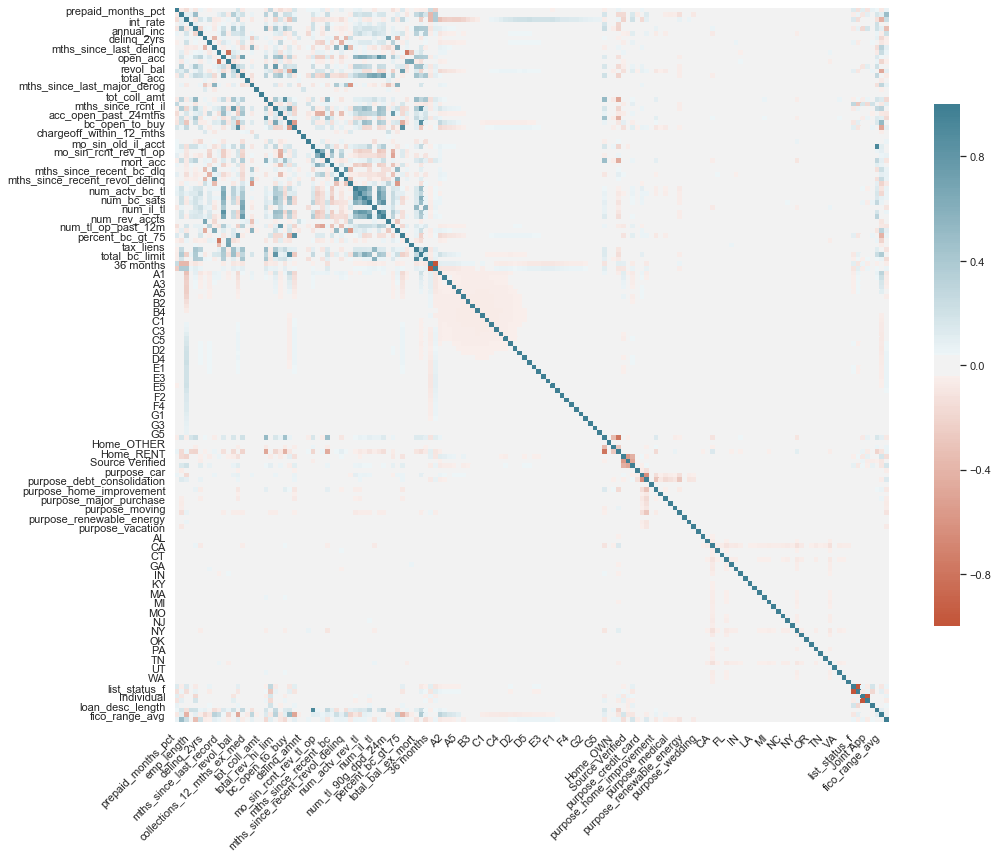

In [112]:
#Make a correlation heatmap

prepayment = paid_off['prepaid_months_pct']
paid_off.drop(labels=['prepaid_months_pct'], axis=1,inplace = True)
paid_off.insert(0, 'prepaid_months_pct', prepayment)

plt.figure(figsize=(16, 16))

corr = paid_off.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True, cbar=True,cbar_kws={"shrink": .6}
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [116]:
paid_off.info(verbose = True, null_counts = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1364914 entries, 42538 to 2778809
Data columns (total 153 columns):
prepaid_months_pct                1364914 non-null float64
funded_amnt                       1364914 non-null float64
int_rate                          1364914 non-null float64
emp_length                        1364914 non-null float64
annual_inc                        1364914 non-null float64
dti                               1364914 non-null float64
delinq_2yrs                       1364914 non-null float64
inq_last_6mths                    1364914 non-null float64
mths_since_last_delinq            1364914 non-null float64
mths_since_last_record            1364914 non-null float64
open_acc                          1364914 non-null float64
pub_rec                           1364914 non-null float64
revol_bal                         1364914 non-null float64
revol_util                        1364914 non-null float64
total_acc                         1364914 non-null float

In [120]:
#Random Forest Regression

target = ['prepaid_months_pct'] 
features = list(paid_off.drop(['prepaid_months_pct'],axis=1).columns)

#Scale features
paid_off[features] = scaler.fit_transform(paid_off[features])

#Create a Classifier
rfr=RandomForestRegressor(n_estimators=200, random_state = 42, 
                                max_depth = 10)

X = paid_off[features]
y = paid_off[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
print(X_train.shape); print(X_test.shape)

rfr.fit(X_train, y_train)

In [119]:
print("Training Score:",rfr.score(X_train, y_train))

print("Test Score:",rfr.score(X_test, y_test))

y_true_rfr = y_test['prepaid_months_pct']
y_pred_rfr = rfr.predict(X_test)

print("RMSE:",round(sqrt(mean_squared_error(y_true_rfr, y_pred_rfr)), 2))

Training Score: 0.24851290840387086
Test Score: 0.239636907049098
RMSE: 0.29


No handles with labels found to put in legend.


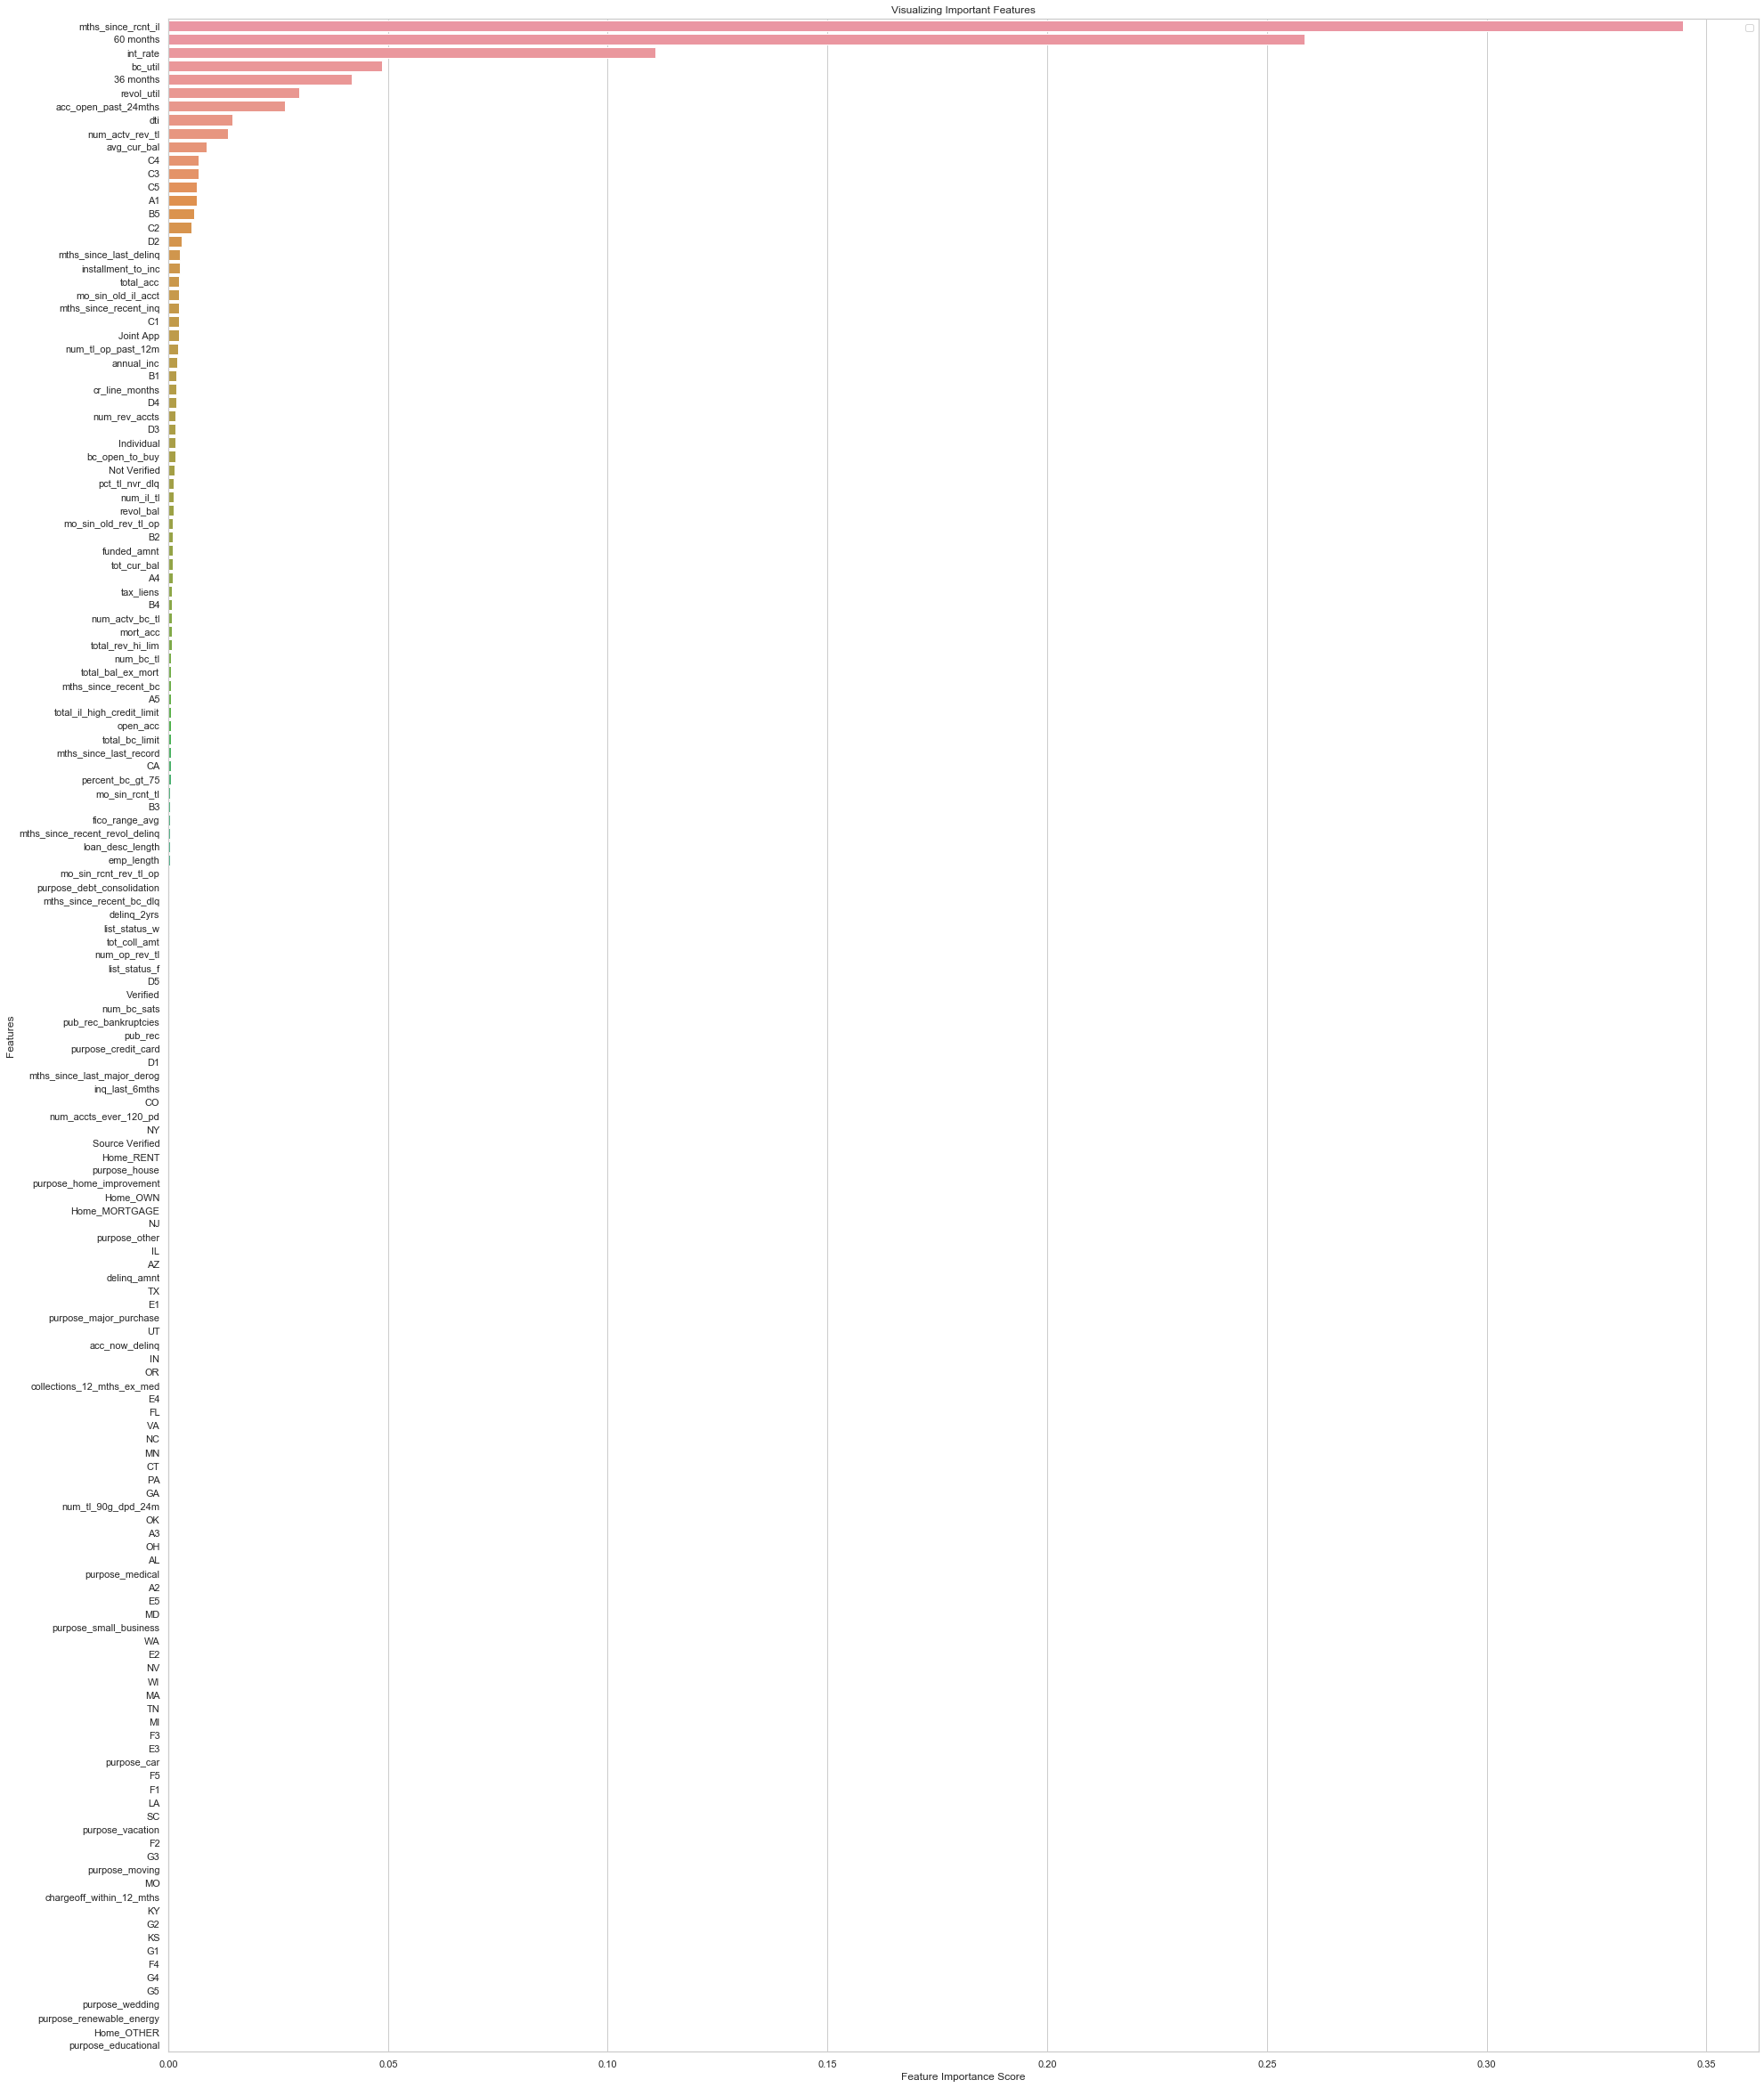

In [121]:
feature_imp = pd.Series(rfr.feature_importances_,index=features).sort_values(ascending=False)
plt.figure(figsize=(32, 42))
sns.barplot(x=feature_imp, y=feature_imp.index)

# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

In [122]:
#Try XGBOOST

X = paid_off[features]
y = paid_off[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
print(X_train.shape); print(X_test.shape)

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', max_depth = 3, n_estimators = 200)

xg_reg.fit(X_train,y_train)

y_pred_xg = xg_reg.predict(X_test)


(955439, 151)
(409475, 151)


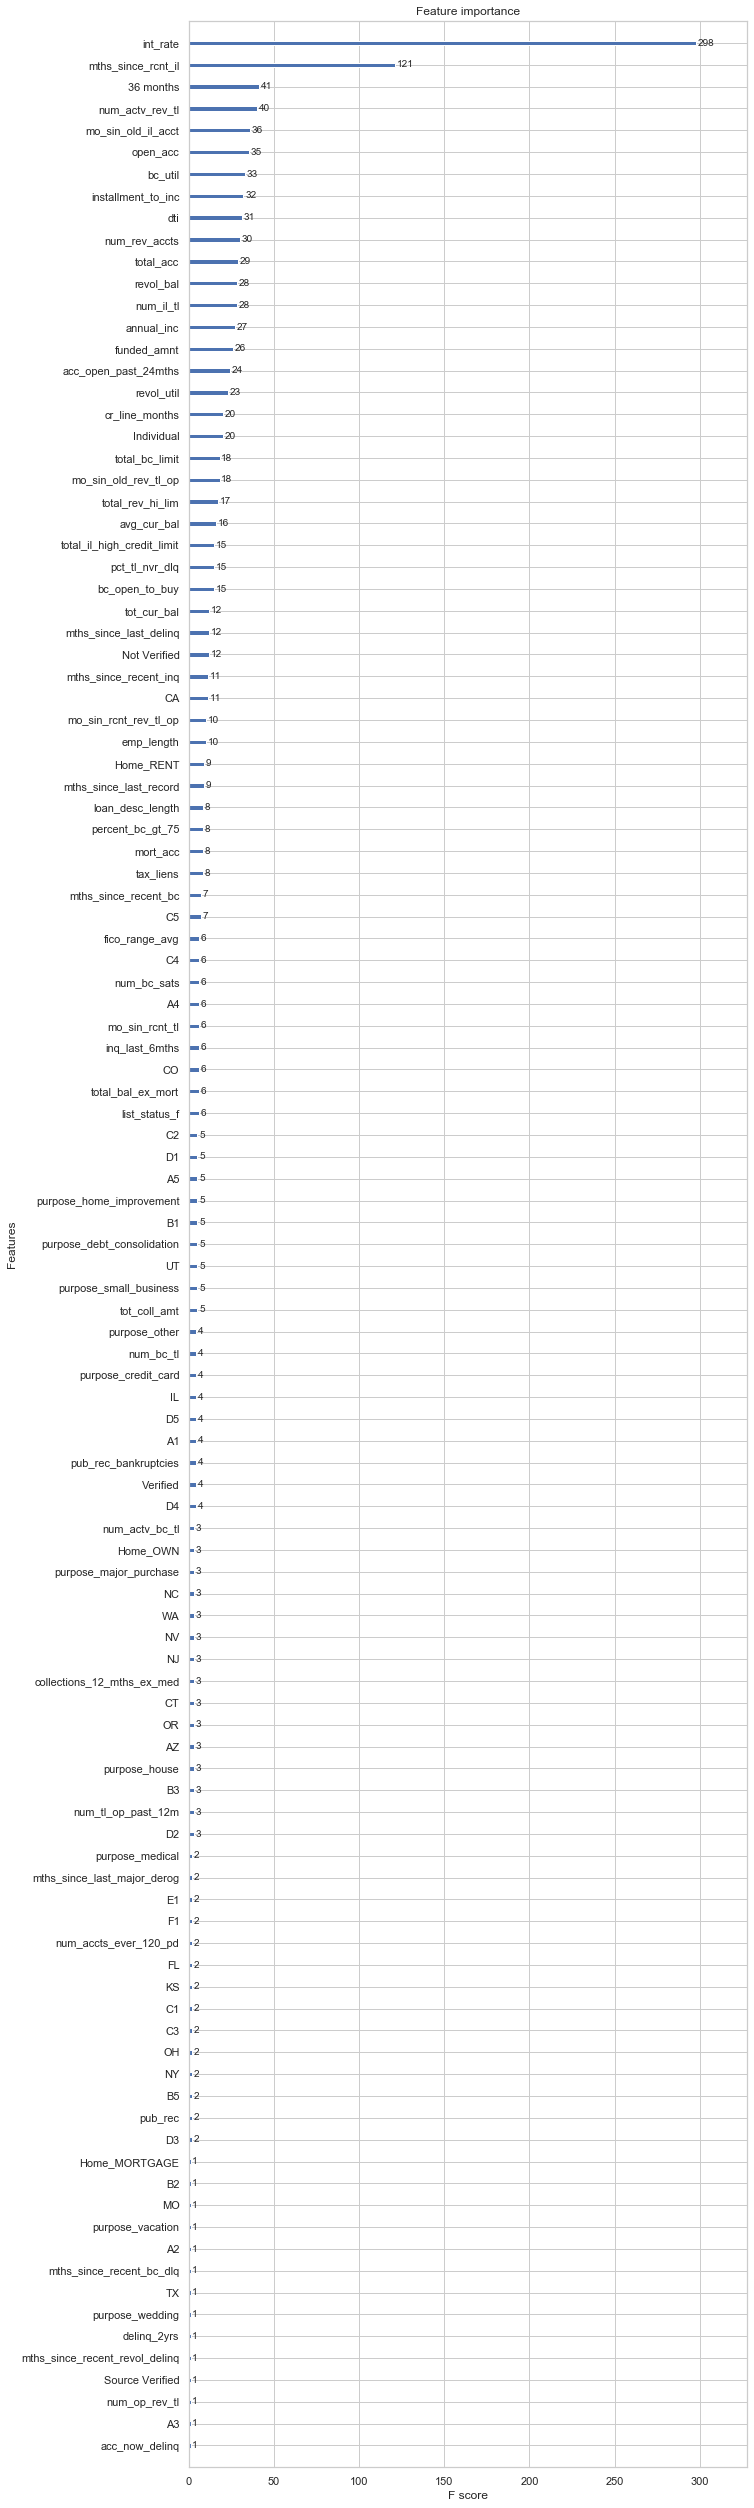

In [138]:
xgb.plot_importance(xg_reg)
#plt.rcParams['figure.figsize'] = [10,45]
plt.show()

In [125]:
print("XGBoost R^2:",xg_reg.score(X_test, y_test))
print("XGBoost RMSE:",round(np.sqrt(mean_squared_error(y_test, y_pred_xg)), 2))

XGBoost R^2: 0.29837973022196074
XGBoost RMSE: 0.28


In [128]:
#Linear Regression


#RFE Feature Selection
#Recursive Feature Elimination (RFE) is based on the idea to repeatedly construct a model 
#and choose either the best or worst performing feature, setting the feature aside and then
#repeating the process with the rest of the features.

sub_grade_remove = list(paid_off.loc[:,'A2':'G4'].columns)
target = ['prepaid_months_pct'] 
features_lr = list(paid_off.drop(['prepaid_months_pct',' 60 months','Home_OTHER',
                                              'Source Verified','purpose_other','GA',
                                              'list_status_w','Joint App']+sub_grade_remove,axis=1).columns)

X = paid_off[features_lr]
y = paid_off[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
print(X_train.shape); print(X_test.shape)

lr = LinearRegression(fit_intercept=True)
rfe = RFE(lr, 20)
rfe = rfe.fit(X_train, y_train)

print ("Features sorted by their rank:")
print (sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), features_lr)))


(955439, 111)
(409475, 111)


C:\Users\armcl\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Features sorted by their rank:
[(1, ' 36 months'), (1, 'Home_MORTGAGE'), (1, 'Home_OWN'), (1, 'Home_RENT'), (1, 'Individual'), (1, 'acc_open_past_24mths'), (1, 'bc_util'), (1, 'cr_line_months'), (1, 'dti'), (1, 'fico_range_avg'), (1, 'int_rate'), (1, 'mort_acc'), (1, 'mths_since_rcnt_il'), (1, 'num_actv_rev_tl'), (1, 'num_il_tl'), (1, 'num_rev_accts'), (1, 'open_acc'), (1, 'pub_rec'), (1, 'pub_rec_bankruptcies'), (1, 'total_acc'), (2, 'revol_util'), (3, 'num_bc_sats'), (4, 'installment_to_inc'), (5, 'list_status_f'), (6, 'pct_tl_nvr_dlq'), (7, 'avg_cur_bal'), (8, 'Not Verified'), (9, 'A1'), (10, 'num_bc_tl'), (11, 'total_bc_limit'), (12, 'CA'), (13, 'purpose_debt_consolidation'), (14, 'purpose_credit_card'), (15, 'mths_since_last_record'), (16, 'num_actv_bc_tl'), (17, 'Verified'), (18, 'delinq_2yrs'), (19, 'mo_sin_old_il_acct'), (20, 'CO'), (21, 'UT'), (22, 'purpose_small_business'), (23, 'mths_since_recent_inq'), (24, 'IL'), (25, 'revol_bal'), (26, 'purpose_house'), (27, 'num_accts_ev

In [129]:
#Top 30 features selected from RFE

features_sorted_by_rank = sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), features_lr))
selected_features = [x[1] for x in features_sorted_by_rank[:30]]
selected_features

[' 36 months',
 'Home_MORTGAGE',
 'Home_OWN',
 'Home_RENT',
 'Individual',
 'acc_open_past_24mths',
 'bc_util',
 'cr_line_months',
 'dti',
 'fico_range_avg',
 'int_rate',
 'mort_acc',
 'mths_since_rcnt_il',
 'num_actv_rev_tl',
 'num_il_tl',
 'num_rev_accts',
 'open_acc',
 'pub_rec',
 'pub_rec_bankruptcies',
 'total_acc',
 'revol_util',
 'num_bc_sats',
 'installment_to_inc',
 'list_status_f',
 'pct_tl_nvr_dlq',
 'avg_cur_bal',
 'Not Verified',
 'A1',
 'num_bc_tl',
 'total_bc_limit']

In [134]:
features_lr2 = [x for x in selected_features if x not in ['CA','Home_OWN','Home_MORTGAGE','Home_RENT']]

X = paid_off[features_lr2]
y = paid_off[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)


#Use p-value to find the significance of variables
ols_model=sm.OLS(y_train,X_train)

result=ols_model.fit()

print(result.summary2())

                          Results: Ordinary least squares
Model:                  OLS                Adj. R-squared (uncentered): 0.053       
Dependent Variable:     prepaid_months_pct AIC:                         1861114.3770
Date:                   2020-05-07 18:09   BIC:                         1861432.1650
No. Observations:       955439             Log-Likelihood:              -9.3053e+05 
Df Model:               27                 F-statistic:                 1999.       
Df Residuals:           955412             Prob (F-statistic):          0.00        
R-squared (uncentered): 0.053              Scale:                       0.41066     
---------------------------------------------------------------------------------------
                         Coef.     Std.Err.       t        P>|t|      [0.025     0.975]
---------------------------------------------------------------------------------------
 36 months               0.0625      0.0008     82.6563    0.0000     0.0610     0.

In [139]:
lr = LinearRegression(fit_intercept=True)

lr.fit(X_train, y_train)

lr_test_score=lr.score(X_test,y_test)

#Return the R^2
print("LR test score:",lr_test_score)

y_pred_lr = lr.predict(X_test)

print("RMSE =", sqrt(mean_squared_error(y_test, y_pred_lr)))

LR test score: 0.21542932425490202
RMSE = 0.2917485662052051
